# <font color="orange">Load modules</font> 

In [5]:
import pandas as pd
import sklearn.metrics
import sklearn.ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.linear_model as lm
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_Task_A import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [6]:
# Now we load the label.csv file and store the smiling labels in y variable, replacing -1 with 0
y = load_images_label_csv("smiling")
y[y==-1] = 0

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Cascade Classifier. We will implement our use case using the Haar Cascade classifier, which is an effective object detection approach which was proposed by Paul Viola and Michael Jones. This is basically a machine learning based approach where a cascade function is trained from a lot of images both positive and negative. Based on the training it is then used to detect the objects in the other images.
So how this works is they are huge individual .xml files with a lot of feature sets and each xml corresponds to a very specific type of use case.

In [7]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True,
                               colour = cv2.IMREAD_GRAYSCALE    # B&W conversion
                              )
imgmgr.bodypart = "smile"
imges = imgmgr.crop_part((48,48), squaring=False, x_offsets=(1/5,4/5), y_offsets = (2/3,1))

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/dataset_AMLS_20-21/celeba/img/ with extension .jpg
3632/5000 images loaded
5000/5000 images loaded


This is an example of an image after processing.

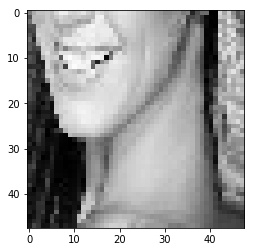

In [8]:
rgb = cv2.cvtColor(imges[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [9]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 1. Random Forest

Compare Gini vs Entropy as criterion. Entropy perform slightly better but error trend across number of estimators is similar, ie big drop at 20.

In [18]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 50, criterion="entropy")
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1871
           1       1.00      1.00      1.00      1879

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

TEST METRICS
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       629
           1       0.85      0.77      0.81       621

    accuracy                           0.82      1250
   macro avg       0.82      0.82      0.82      1250
weighted avg       0.82      0.82      0.82      1250



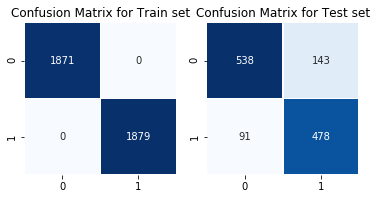

In [11]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

No handles with labels found to put in legend.


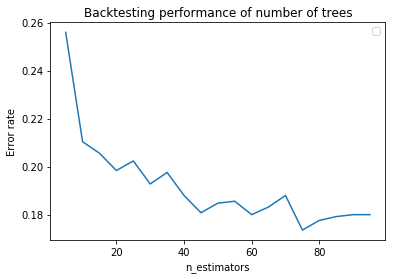

In [12]:
n_estimators=np.arange(5, 100, 5)
#
# Dictionary containing (<n_estimators>, <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

In [19]:
param_grid = {'n_estimators': [20, 40, 60, 80],
              'max_depth': [2, 7, 15, 20]}

In [20]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=50),
             param_grid={'max_depth': [2, 7, 15, 20],
                         'n_estimators': [20, 40, 60, 80]})

In [21]:
grid_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=60)

So, by running some cross-validation jobs and tuning the hyper-parameters, it is clear that our Random Forest classifier performs much better when a large depth of trees is allowed and "n_estimators" number is in the 60-80 range. Also, by choosing "entropy" rather than "gini" as the function to measure the quality of split, the scoring improves slightly.

In [22]:
print(grid_clf.score(X_test, y_test))

0.8176


### 2. Convolutional Neural Network

Resize and manipulate the train and tests sets in order to be in the right format for the CNN implementation.

In [6]:
X = np.empty(((len(imges), *np.asarray(imges[0]).shape)))
for i in range(len(imges)):
    X[i] = np.asarray(imges[i])

# shuffle all the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

X = X.reshape(5000,48, 48,1)

print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

float64 0.0 255.0 (5000, 48, 48, 1)
int64 0 1 (5000,)


In [7]:
# CNN Model
nb_filters = 16
nb_pool = 2
nb_conv = 4
nb_classes = 2

model = models.Sequential()

model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_classes))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 45, 16)        272       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 16)        4112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7056)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                451648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_test, y_test))

Epoch 1/50
118/118 [==============================] - 9s 78ms/step - loss: 2.1860 - accuracy: 0.5275 - val_loss: 0.6752 - val_accuracy: 0.6040
Epoch 2/50
118/118 [==============================] - 11s 92ms/step - loss: 0.6238 - accuracy: 0.6368 - val_loss: 0.5080 - val_accuracy: 0.7488
Epoch 3/50
118/118 [==============================] - 11s 97ms/step - loss: 0.5260 - accuracy: 0.7357 - val_loss: 0.5087 - val_accuracy: 0.7432
Epoch 4/50
118/118 [==============================] - 12s 103ms/step - loss: 0.4873 - accuracy: 0.7645 - val_loss: 0.4805 - val_accuracy: 0.7752
Epoch 5/50
118/118 [==============================] - 13s 110ms/step - loss: 0.4648 - accuracy: 0.7672 - val_loss: 0.4714 - val_accuracy: 0.7864
Epoch 6/50
118/118 [==============================] - 13s 108ms/step - loss: 0.4193 - accuracy: 0.7949 - val_loss: 0.4583 - val_accuracy: 0.7896
Epoch 7/50
118/118 [==============================] - 13s 111ms/step - loss: 0.3655 - accuracy: 0.8261 - val_loss: 0.4497 - val_accura